In [1]:
import time
import scipy
import numpy as np
import pandas as pd
import winsound

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam, NAdam
from torch.optim.lr_scheduler import OneCycleLR as OCR
from torch.utils.data import RandomSampler, SequentialSampler

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv, SAGEConv, GATConv, Linear, to_hetero
from torch_geometric.nn import models as pyg_models
from torch_geometric.sampler import HGTSampler
from torch_geometric.loader import DataLoader, HGTLoader, NeighborLoader, NodeLoader
from tqdm import tqdm

from UltilityFunctions import *


# print(matplotlib.__version__)
# print(nx.__version__)
print(torch.__version__)

2.0.0+cu118


In [2]:
torch.manual_seed(43)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 960
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# SLAC 10-Genre

## Data Preperations

In [3]:
# # Complete Dataset
G = complete_graph(".\\slac\\embeddings\\all")


loading edgelists...
- notes.edgelist
- program.edgelist
- tempo.edgelist
- time.signature.edgelist
Nodes: 93553
Edges: 786635


In [4]:
nodes = pd.DataFrame((list(G.nodes)), columns=['name'])
edges = pd.DataFrame(np.array(list(G.edges)), columns=['source', 'target'])

In [5]:
node_categories = node_cat_dict(nodes)
node_categories.keys()

node_cat_dict took 0.18 secs to run


dict_keys(['note_group', 'pitch', 'program', 'MIDI', 'duration', 'velocity', 'time_sig', 'tempo'])

In [6]:
nodes_df_complete = pd.read_csv('.\slac\Contents of Slac\\nodes_complete.csv')
edges_df_complete = pd.read_csv('.\slac\Contents of Slac\edges_complete.csv')
print('Done')

Done


In [7]:
node_types = set(nodes_df_complete['node_type'])
node_types


{'MIDI',
 'duration',
 'note_group',
 'pitch',
 'program',
 'tempo',
 'time_sig',
 'velocity'}

In [8]:
edge_types = ["MIDI__has__tempo",
                   "MIDI__in__time_sig",
                   "MIDI__has__program",
                   "MIDI__has__note_group",
                   "note_group__has__velocity",
                   "note_group__has__duration",
                   "note_group__contains__pitch"]

In [9]:
names_list = flatten_lol(node_categories.values())


In [10]:
encoder = Encoder(names_list, n_labels=10)


In [11]:
input_node_dict = {node_type: {'x': encoder.
                    encode_nodes(nodes_df_complete.
                    loc[nodes_df_complete['node_type'] == node_type, ['name']])}
                    for node_type in node_types}

encode_nodes took 3.49 secs to run
encode_nodes took 0.02 secs to run
encode_nodes took 0.01 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run


In [12]:
node_enc_to_idx = {node_type: {encoder.decode_value(node_enc.item()): i for i, node_enc in enumerate(input_node_dict[node_type]['x'])} for node_type in node_types}

In [13]:
input_edge_dict = dict()
for edge_type in edge_types:
    node_type_s, node_type_t = edge_type.split('__')[0], edge_type.split('__')[2]

    edge_df = edges_df_complete.loc[edges_df_complete['edge_type'] == edge_type, ['source', 'target']].copy()

    edge_df['source'], edge_df['target'] = edge_df['source'].map(node_enc_to_idx[node_type_s]), edge_df['target'].map(node_enc_to_idx[node_type_t])

    input_edge_dict[edge_type] = {'edge_index': torch.tensor(edge_df.values).T}


In [14]:
# Extract the label of each Midi.
midi_val = nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']].values
midi_class_10 = [midi_type(s[0], 10) for s in midi_val]

lb = LabelEncoder()
y_10 = torch.from_numpy(lb.fit_transform(midi_class_10))  # .type(torch.LongTensor)

lb.classes_

array(['Alternative', 'Baroque', 'Bop', 'Hardcore_Rap', 'Metal', 'Modern',
       'Pop_Rap', 'Romantic', 'Swing', 'Traditional'], dtype='<U12')

In [15]:
input_node_dict_10 = input_node_dict.copy()

input_node_dict_10['MIDI']['y'] = y_10

## Graph Construction

In [26]:
H_10 = HeteroData(input_node_dict_10, **input_edge_dict)
H_10 = T.ToUndirected()(H_10)
print(H_10)

HeteroData(
  note_group={ x=[92484, 1] },
  duration={ x=[570, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  tempo={ x=[23, 1] },
  pitch={ x=[93, 1] },
  time_sig={ x=[14, 1] },
  velocity={ x=[11, 1] },
  program={ x=[108, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 250] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 239] },
  (program, rev_has, MIDI)={ edge_index=[2, 1392] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 135160] },
  (velocity, rev_has, note_group)={ edge_index=[2, 118626] },
  (duration, rev_has, note_group)={ edge_index=[2, 92484] },
  (pitch, rev_contains, note_group)={ edge_index=[2, 438

## GNN Construction

In [27]:
model_10 = pyg_models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb.classes_)))

model_10 = to_hetero(model_10, H_10.metadata(), aggr='sum')




## 10-Fold Cross Validation

In [28]:
loss_mean, acc_mean, models = cross_val(
     dataset=H_10,
    model=model_10,
    folds=10,
    epochs=1600,
    lr=0.02,
    device=device,
    weight_decay=0.0005,
    lr_decay_factor=0.5,
    exp_factor=1,
    lr_decay_step_size=50
)


Transfering dataset to device cuda
Done
________________________________________________________________________________
Starting Cross Validation
________________________________________________________________________________
Transfering Model to devicecuda
Resetting parameters
Lazy Initialization of Model
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Resetting SAGEConv
Synchronizing GPU
Starting Training
fold : 0 | epoch : 1 | train_loss : 865293.6875 | val_loss : 1111599.0 | test_acc : 0.0 | 
-------------------------------

## Evaluation and Confusion Matrix

In [29]:
predicted, mask = voting(models, H_10, device=device)

predicted


array([5, 1, 5, 9, 5, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 3, 0, 4, 4, 4], dtype=int64)

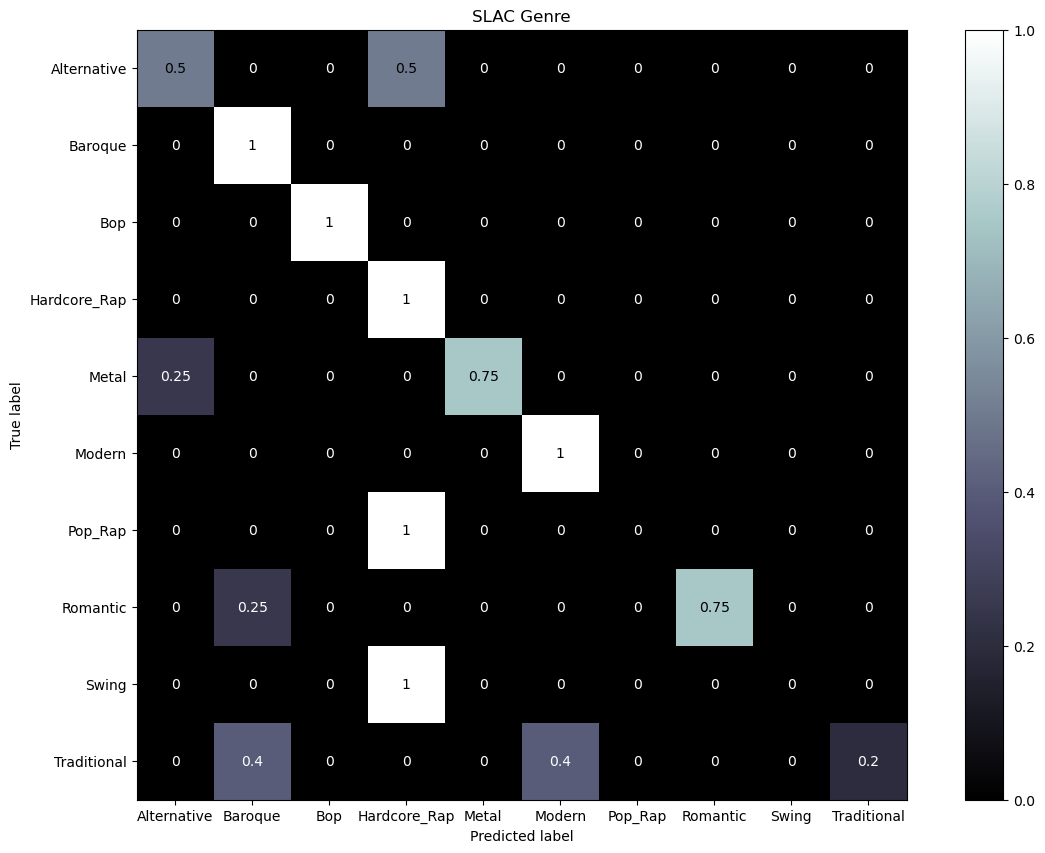

In [30]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(H_10['MIDI'].y[mask].to('cpu')), y_pred=lb.inverse_transform(predicted),
                                                cmap='bone', normalize='true')

disp.ax_.set_title('SLAC Genre')
disp.figure_.set_size_inches(15, 10)
plt.show()

In [31]:
save_models(models, '.\\slac\\models_10\\')

Models saved at .\slac\models_10\
